In [1]:
# Extended and Enhanced MVTec AD Anomaly Detection Script

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
import cv2
from sklearn.metrics import roc_auc_score

###########################################
# 1. Test Dataset: Merging Multiple Folders
###########################################

class MVTecTestDataset(Dataset):
    def __init__(self, test_dirs, transform=None):
        self.image_paths = []
        for test_dir in test_dirs:
            for fname in os.listdir(test_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(test_dir, fname))
        self.image_paths.sort()
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

#############################################
# 2. Improved Convolutional Autoencoder Model
#############################################

class ImprovedAutoencoder(nn.Module):
    def __init__(self):
        super(ImprovedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#############################################
# 3. Utilities
#############################################

def compute_pixel_error_map(original, reconstructed):
    error = torch.abs(original - reconstructed)
    return error.mean(dim=1, keepdim=True).squeeze().cpu().numpy()

def get_mask_path(img_path):
    return img_path.replace("/test", "/ground_truth").replace(".png", "_mask.png")

def compute_iou(error_map, mask_path, threshold=0.5):
    if not os.path.exists(mask_path): return None
    mask = Image.open(mask_path).convert("L").resize(error_map.shape[::-1], Image.NEAREST)
    gt = (np.array(mask) > 128).astype(np.uint8)
    pred = (error_map > threshold).astype(np.uint8)
    intersection = (pred & gt).sum()
    union = (pred | gt).sum()
    return float(intersection) / union if union > 0 else 1.0

def compute_roc_auc(error_map, mask_path):
    if not os.path.exists(mask_path): return None
    mask = Image.open(mask_path).convert("L").resize(error_map.shape[::-1], Image.NEAREST)
    y_true = (np.array(mask).flatten() > 128).astype(np.uint8)
    y_score = error_map.flatten()
    return roc_auc_score(y_true, y_score) if y_true.sum() > 0 else None

def generate_heatmap(error_map, original_tensor):
    error_norm = ((error_map - error_map.min()) / (error_map.max() - error_map.min() + 1e-8) * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(error_norm, cv2.COLORMAP_JET)
    original_np = (original_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    overlay = cv2.addWeighted(original_np, 0.6, heatmap, 0.4, 0)
    return overlay

def save_visualization(overlay, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

#############################################
# 4. Evaluation Function
#############################################

def evaluate(test_loader, model, device, input_base, output_base, threshold=0.3):
    model.eval()
    results = []
    for image, img_path in test_loader:
        image = image.to(device)
        with torch.no_grad():
            recon = model(image)
        error_map = compute_pixel_error_map(image, recon)
        mask_path = get_mask_path(img_path[0])
        iou = compute_iou(error_map, mask_path, threshold)
        auc = compute_roc_auc(error_map, mask_path)
        error_percent = np.mean(error_map) * 100
        rel_path = os.path.relpath(img_path[0], input_base)
        out_path = os.path.join(output_base, rel_path)
        overlay = generate_heatmap(error_map, image.squeeze())
        save_visualization(overlay, out_path)
        results.append({
            "file": rel_path,
            "error_percent": error_percent,
            "iou": iou,
            "auc": auc
        })
    return pd.DataFrame(results)

#############################################
# 5. Main Execution
#############################################

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_dirs = [
        "Input/bottle/test/broken_large",
        "Input/bottle/test/broken_small",
        "Input/bottle/test/contamination",
        "Input/carpet/test/color",
        "Input/carpet/test/cut",
        "Input/carpet/test/hole",
        "Input/carpet/test/thread"
    ]
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    test_dataset = MVTecTestDataset(test_dirs, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    model = ImprovedAutoencoder().to(device)
    # model.load_state_dict(torch.load("improved_autoencoder.pth"))  # Optional
    df = evaluate(
        test_loader,
        model,
        device,
        input_base="Input",
        output_base="Output/Heatmaps",
        threshold=0.3
    )
    print(df)
    df.to_csv("Output/anomaly_summary.csv", index=False)


                                 file  error_percent       iou       auc
0    bottle\test\broken_large\000.png      32.899249  0.011234  0.219511
1    bottle\test\broken_large\001.png      33.469203  0.062992  0.324568
2    bottle\test\broken_large\002.png      33.023676  0.019620  0.262755
3    bottle\test\broken_large\003.png      34.421515  0.059129  0.173798
4    bottle\test\broken_large\004.png      32.801196  0.006389  0.229028
..                                ...            ...       ...       ...
130        carpet\test\thread\014.png      16.369797  0.001700  0.397659
131        carpet\test\thread\015.png      16.268934  0.036421  0.879002
132        carpet\test\thread\016.png      16.342086  0.024813  0.853798
133        carpet\test\thread\017.png      15.845355  0.000000  0.276150
134        carpet\test\thread\018.png      16.212955  0.011908  0.802067

[135 rows x 4 columns]


       error_percent         iou         auc
count     135.000000  135.000000  135.000000
mean       23.346540    0.025657    0.457232
std         8.570827    0.039747    0.207745
min        14.086407    0.000000    0.149748
25%        15.299722    0.004673    0.278250
50%        16.194727    0.016228    0.428605
75%        32.492346    0.033796    0.553237
max        33.923218    0.307272    0.917804
                               file  error_percent       iou       auc
0  bottle\test\broken_large\000.png      32.426572  0.006890  0.215295
1  bottle\test\broken_large\001.png      32.955858  0.046628  0.322510
2  bottle\test\broken_large\002.png      32.499838  0.010535  0.258838
3  bottle\test\broken_large\003.png      33.923218  0.042219  0.175959
4  bottle\test\broken_large\004.png      32.328361  0.007355  0.233157


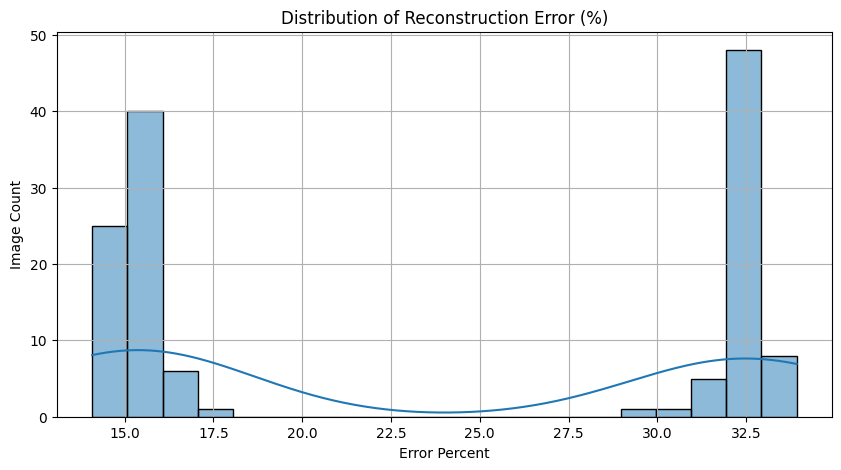

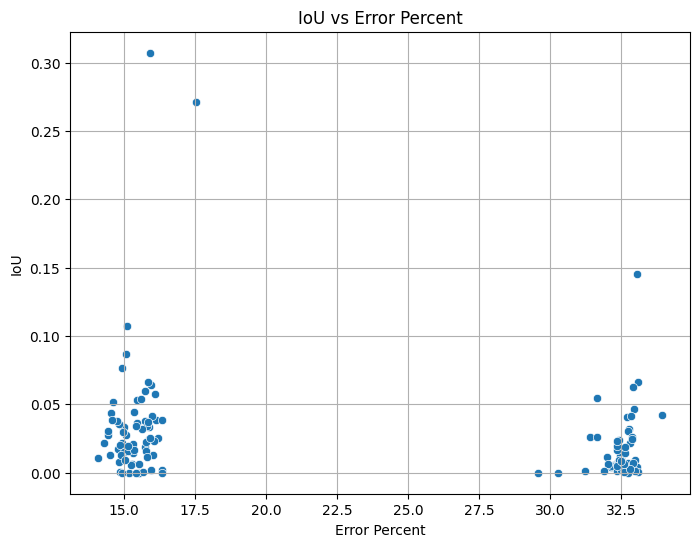

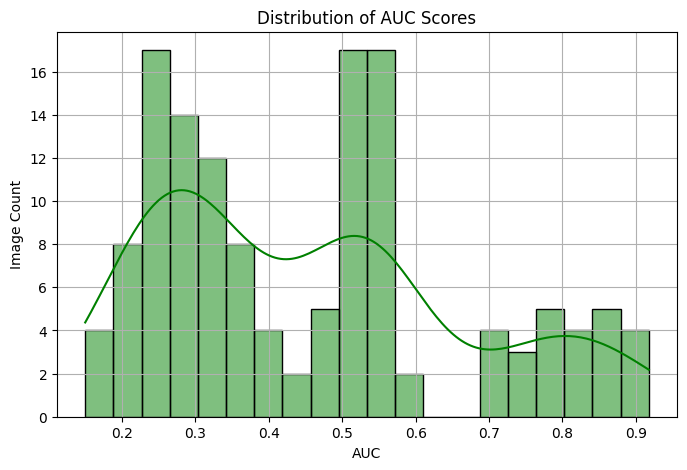

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
df = pd.read_csv("Output/anomaly_summary.csv")

# Basic info
print(df.describe())
print(df.head())

# Error % distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["error_percent"], bins=20, kde=True)
plt.title("Distribution of Reconstruction Error (%)")
plt.xlabel("Error Percent")
plt.ylabel("Image Count")
plt.grid(True)
plt.show()

# IoU vs Error %
plt.figure(figsize=(8, 6))
sns.scatterplot(x="error_percent", y="iou", data=df)
plt.title("IoU vs Error Percent")
plt.xlabel("Error Percent")
plt.ylabel("IoU")
plt.grid(True)
plt.show()

# AUC distribution
if "auc" in df.columns and df["auc"].notna().any():
    plt.figure(figsize=(8, 5))
    sns.histplot(df["auc"].dropna(), bins=20, kde=True, color="green")
    plt.title("Distribution of AUC Scores")
    plt.xlabel("AUC")
    plt.ylabel("Image Count")
    plt.grid(True)
    plt.show()


In [ ]:


import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
import cv2
from sklearn.metrics import roc_auc_score

###########################################
# 1. Test Dataset
###########################################

class MVTecTestDataset(Dataset):
    def __init__(self, test_dirs, transform=None):
        self.image_paths = []
        for test_dir in test_dirs:
            for fname in os.listdir(test_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(test_dir, fname))
        self.image_paths.sort()
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

#############################################
# 2. Autoencoder Models
#############################################

class ImprovedAutoencoder(nn.Module):
    def __init__(self):
        super(ImprovedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class CarpetPatchAutoencoder(nn.Module):
    def __init__(self):
        super(CarpetPatchAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding=1), nn.ReLU(),
            nn.Conv2d(32, 3, 3, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

#############################################
# 3. Utilities
#############################################

def compute_pixel_error_map(original, reconstructed):
    error = torch.abs(original - reconstructed)
    return error.mean(dim=1, keepdim=True).squeeze().cpu().numpy()

def get_mask_path(img_path):
    return img_path.replace("/test", "/ground_truth").replace(".png", "_mask.png")

def compute_iou(error_map, mask_path, threshold=0.5):
    if not os.path.exists(mask_path): return None
    mask = Image.open(mask_path).convert("L").resize(error_map.shape[::-1], Image.NEAREST)
    gt = (np.array(mask) > 128).astype(np.uint8)
    pred = (error_map > threshold).astype(np.uint8)
    intersection = (pred & gt).sum()
    union = (pred | gt).sum()
    return float(intersection) / union if union > 0 else 1.0

def compute_roc_auc(error_map, mask_path):
    if not os.path.exists(mask_path): return None
    mask = Image.open(mask_path).convert("L").resize(error_map.shape[::-1], Image.NEAREST)
    y_true = (np.array(mask).flatten() > 128).astype(np.uint8)
    y_score = error_map.flatten()
    return roc_auc_score(y_true, y_score) if y_true.sum() > 0 else None

def generate_heatmap(error_map, original_tensor):
    error_norm = ((error_map - error_map.min()) / (error_map.max() - error_map.min() + 1e-8) * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(error_norm, cv2.COLORMAP_JET)
    original_np = (original_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    overlay = cv2.addWeighted(original_np, 0.6, heatmap, 0.4, 0)
    return overlay

def save_visualization(overlay, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

#############################################
# 4. Evaluation Function
#############################################

def evaluate(test_loader, model_bottle, model_carpet, device, input_base, output_base, threshold=0.3):
    model_bottle.eval()
    model_carpet.eval()
    results = []
    patch_size = 128
    stride = 64

    for image, img_path in test_loader:
        image = image.to(device)
        is_carpet = "carpet" in img_path[0].lower()
        mask_path = get_mask_path(img_path[0])

        if is_carpet:
            _, _, H, W = image.shape
            error_map = np.zeros((H, W), dtype=np.float32)
            count_map = np.zeros((H, W), dtype=np.uint8)
            with torch.no_grad():
                for i in range(0, H - patch_size + 1, stride):
                    for j in range(0, W - patch_size + 1, stride):
                        patch = image[:, :, i:i+patch_size, j:j+patch_size]
                        recon = model_carpet(patch)
                        patch_error = compute_pixel_error_map(patch, recon)
                        error_map[i:i+patch_size, j:j+patch_size] += patch_error
                        count_map[i:i+patch_size, j:j+patch_size] += 1
                error_map = error_map / np.maximum(count_map, 1)
        else:
            with torch.no_grad():
                recon = model_bottle(image)
            error_map = compute_pixel_error_map(image, recon)

        iou = compute_iou(error_map, mask_path, threshold)
        auc = compute_roc_auc(error_map, mask_path)
        error_percent = np.mean(error_map) * 100
        rel_path = os.path.relpath(img_path[0], input_base)
        out_path = os.path.join(output_base, rel_path)
        overlay = generate_heatmap(error_map, image.squeeze())
        save_visualization(overlay, out_path)
        results.append({
            "file": rel_path,
            "error_percent": error_percent,
            "iou": iou,
            "auc": auc
        })
    return pd.DataFrame(results)

#############################################
# 5. Main Execution
#############################################

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_dirs = [
        "Input/bottle/test/broken_large",
        "Input/bottle/test/broken_small",
        "Input/bottle/test/contamination",
        "Input/carpet/test/color",
        "Input/carpet/test/cut",
        "Input/carpet/test/hole",
        "Input/carpet/test/thread"
    ]
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    test_dataset = MVTecTestDataset(test_dirs, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    model_bottle = ImprovedAutoencoder().to(device)
    model_carpet = CarpetPatchAutoencoder().to(device)
    # model_bottle.load_state_dict(torch.load("model_bottle.pth"))
    # model_carpet.load_state_dict(torch.load("model_carpet_patch.pth"))
    df = evaluate(
        test_loader,
        model_bottle,
        model_carpet,
        device,
        input_base="Input",
        output_base="Output/Heatmaps",
        threshold=0.3
    )
    print(df)
    df.to_csv("Output/anomaly_summary.csv", index=False)

                                 file  error_percent       iou       auc
0    bottle\test\broken_large\000.png      32.426572  0.006890  0.215295
1    bottle\test\broken_large\001.png      32.955858  0.046628  0.322510
2    bottle\test\broken_large\002.png      32.499838  0.010535  0.258838
3    bottle\test\broken_large\003.png      33.923218  0.042219  0.175959
4    bottle\test\broken_large\004.png      32.328361  0.007355  0.233157
..                                ...            ...       ...       ...
130        carpet\test\thread\014.png      15.949209  0.001762  0.401585
131        carpet\test\thread\015.png      15.825717  0.037058  0.878942
132        carpet\test\thread\016.png      15.904400  0.025118  0.853891
133        carpet\test\thread\017.png      15.403901  0.000000  0.282410
134        carpet\test\thread\018.png      15.788688  0.011565  0.802193

[135 rows x 4 columns]


In [5]:
torch.save(model_bottle.state_dict(), "model_bottle.pth")
torch.save(model_carpet.state_dict(), "model_carpet_patch.pth")

Adding a classifier Model to detect Bottel and Carpet images

Epoch 1/10 - Loss: 0.6695
Epoch 2/10 - Loss: 0.3087
Epoch 3/10 - Loss: 0.0124
Epoch 4/10 - Loss: 0.0013
Epoch 5/10 - Loss: 0.0008
Epoch 6/10 - Loss: 0.0006
Epoch 7/10 - Loss: 0.0004
Epoch 8/10 - Loss: 0.0002
Epoch 9/10 - Loss: 0.0001
Epoch 10/10 - Loss: 0.0001


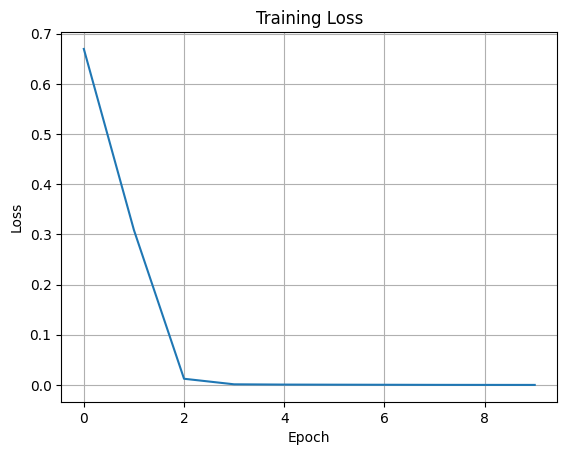

 Model saved as classifier_bottle_carpet.pth


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ----------- Model -----------
class BottleCarpetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2, 1), nn.ReLU(),  # 128
            nn.Conv2d(16, 32, 3, 2, 1), nn.ReLU(),  # 64
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(),  # 32
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 2)  # [bottle, carpet]
        )

    def forward(self, x):
        return self.net(x)

# ----------- Data Setup -----------
DATA_DIR = "Input"
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(
    root=os.path.join(DATA_DIR),
    transform=transform,
    is_valid_file=lambda x: "train/good" in x.replace("\\", "/")
)

# Assign labels manually: 0 = bottle, 1 = carpet
label_map = {"bottle": 0, "carpet": 1}
train_data.targets = [label_map[img_path.split(os.sep)[-4]] for img_path, _ in train_data.samples]

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

# ----------- Training -----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BottleCarpetClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 10
losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")

# Optional: plot training loss
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# ----------- Save Model -----------
torch.save(model.state_dict(), "Models_dump\classifier_bottle_carpet.pth")
print(" Model saved as classifier_bottle_carpet.pth")

